# Optical Flow
## Coded By: Abhinav Gupta, 20171059
- We implement the Lucas Kanade algorithm to compute the optical flow between images.- 
- The idea behind Lucas Kanade is to find movement of pixels in the 2 frames by finding the least square solution on a vector using the gradient in the x&y directions which would help predict the movement of the pixels.
- We use the computed flow to detect, segment and track objects in videos. 

In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from PIL import Image
import sys
import os
from scipy import signal
import glob

In [102]:
def compute_flow_map(u, v, gran=8):
    flow_map = np.zeros(u.shape)

    for y in range(flow_map.shape[0]):
        for x in range(flow_map.shape[1]):
            if y % gran == 0 and x % gran == 0:
                dx = int(u[y, x]) 
                dy = int(v[y, x])
                if dx > 0 or dy > 0:
                    cv2.arrowedLine(flow_map, (x, y), (x + dx, y + dy), 255, 1)
    return flow_map

In [103]:
def optical_flow(I1g, I2g, window_size, tau=1e-2):
    #Define our kernels to calculate gradients
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t by conv2d
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode='same') + \
        scipy.signal.convolve2d(I1g, -kernel_t, boundary='symm', mode='same')
    
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    
    # For each window calculate the vectors [u,v]    
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            
            A = [ [np.sum(Ix*Ix),np.sum(Ix*Iy)], [np.sum(Iy*Ix), np.sum(Iy*Iy)] ]
            A = np.array(A)
    
            b = [-np.sum(Ix*It), -np.sum(Iy*It)]
            b = np.array(b)
            
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            U,D,V_T = np.linalg.svd(A.T.dot(A))
            if np.min(D) < tau:
                u[i,j]=0
                v[i,j]=0                
            
            else:
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)
                
    return [u,v]

In [104]:
img1 = cv2.imread('./data/Dumptruck/frame10.png')
img2 = cv2.imread('./data/Dumptruck/frame11.png')
img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

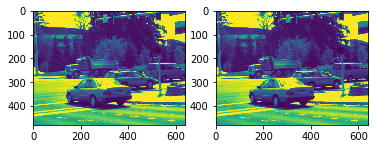

In [105]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img1g)
f.add_subplot(1,2, 2)
plt.imshow(img2g)
plt.show()

In [106]:
u1,v1 = optical_flow(img1g, img2g, 15)

In [120]:
def display_opticalflow_results(im1,im2,u,v,fig_size=(16,16),arrow_thres=0.02):
    
    fig = plt.figure(figsize=fig_size)
    
    # Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Image T:1")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Image T:2")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='gray')
    ax.set_title("U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("arc(v/u)")
    ax.axis('off')
    
    plt.show()
    
    return None

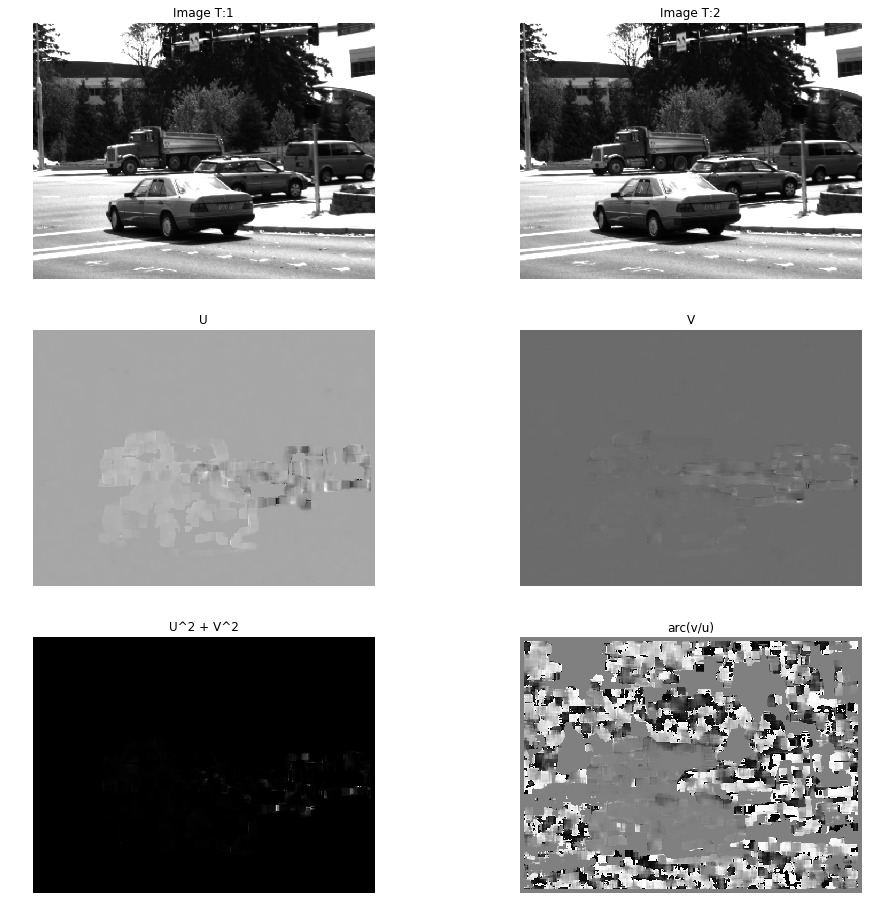

In [115]:
display_opticalflow_results(img1g,img2g,u1,v1)

In [122]:
def compute_flow_map(u, v, gran=8):
    flow_map = np.zeros(u.shape)

    for y in range(flow_map.shape[0]):
        for x in range(flow_map.shape[1]):
            if y % gran == 0 and x % gran == 0:
                dx = int(u[y, x]) 
                dy = int(v[y, x])
                if dx > 0 or dy > 0:
                    cv2.arrowedLine(flow_map, (x, y), (x + dx, y + dy), 255, 1)
    return flow_map

In [123]:
map1 = compute_flow_map(u1,v1)

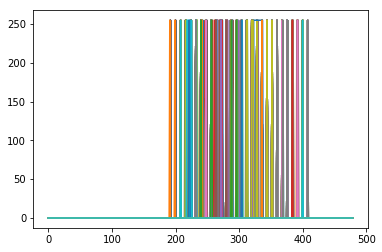

In [133]:
fig = plt.figure()
plt.plot(map1)
plt.show()

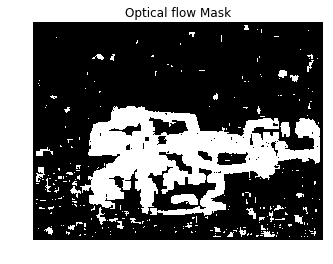

In [134]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow( (u1*u1 + v1*v1>0.02),cmap='gray')
ax.set_title("Optical flow Mask")

ax.axis('off')
plt.show()

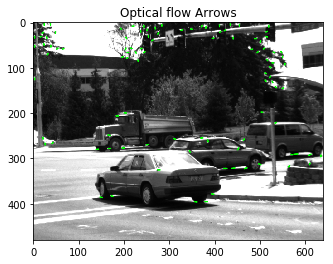

In [132]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img1g,cmap='gray')
ax.set_title("Optical flow Arrows")

kp = cv2.goodFeaturesToTrack(img1g, 100, 0.01, 10, 3)
for arrow_ind in kp:
    x,y = arrow_ind[0]
    y = int(y)
    x = int(x)
    ax.arrow(x,y,u1[y,x],v1[y,x],head_width = 1, head_length = 5, color = (0,1,0))
plt.show()